In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.decomposition import PCA
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, Flatten, Conv1D
from tensorflow.keras.layers import Reshape, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from scipy.signal import lfilter
from scipy.interpolate import LinearNDInterpolator

# from google.colab import drive
# drive.mount('/content/drive')

In [121]:
def GetAfxy(a,b,c,d):
    A = np.zeros((3,3))
    A[0,0] = (b*d)/(a*c*(a + b)*(c + d))
    A[0,1] = (b*(c - d))/(a*c*d*(a + b))
    A[0,2] = -(b*c)/(a*d*(a + b)*(c + d))

    A[1,0] = (d*(a - b))/(a*b*c*(c + d))
    A[1,1] = ((a - b)*(c - d))/(a*b*c*d)
    A[1,2] = -(c*(a - b))/(a*b*d*(c + d))

    A[2,0] = -(a*d)/(b*c*(a + b)*(c + d))
    A[2,1] = -(a*(c - d))/(b*c*d*(a + b))
    A[2,2] = (a*c)/(b*d*(a + b)*(c + d))
    return A

def GetAfxx(a,b,c,d):
    A = np.zeros((3,3))
    A[0,1] = 2/(a*(a + b))
    A[1,1] = -2/(a*b)
    A[2,1] = 2/(b*(a + b))
    return A

def GetAfx(a,b,c,d):
    A = np.zeros((3,3))
    A[0,1] = -b/(a*(a + b))
    A[1,1] = -(a - b)/(a*b)
    A[2,1] = a/(b*(a + b))
    return A


def GetAfyy(a,b,c,d):
    A = np.zeros((3,3))
    A[1,0] = 2/(c*(c + d))
    A[1,1] = -2/(c*d)
    A[1,2] = 2/(d*(c + d))
    return A

def GetAfy(a,b,c,d):
    A = np.zeros((3,3))
    A[1,0] = -d/(c*(c + d))
    A[1,1] = -(c - d)/(c*d)
    A[1,2] = c/(d*(c + d))
    return A

def getA(C,X,Y):
    a = X[1,1]-X[0,1]
    b = X[2,1]-X[1,1]
    c = Y[1,1]-Y[1,0]
    d = Y[1,2]-Y[1,1]
    Afxy = GetAfxy(a,b,c,d)
    Afxx = GetAfxx(a,b,c,d)
    Afyy = GetAfyy(a,b,c,d)
    Afx = GetAfx(a,b,c,d)
    Afy = GetAfy(a,b,c,d)
    Af = np.zeros((3,3))
    Af[1,1] = 1
    A = C[0]*Af + C[1]*Afx + C[2]*Afy + C[3]*Afxx + C[4]*Afyy + C[5]*Afxy
    return A


def Aij(Cij,u_bc,X,Y):   
    n = u_bc.shape[0]
    Ap = np.zeros((n-2,n-2))
    An = np.zeros((n-2,n-2))
    As = np.zeros((n-2,n-2))
    Aw = np.zeros((n-2,n-2))
    Ae = np.zeros((n-2,n-2))
    Anw = np.zeros((n-2,n-2))
    Ane = np.zeros((n-2,n-2))
    Asw = np.zeros((n-2,n-2))
    Ase = np.zeros((n-2,n-2))
    for i in range(0,n-2):
        for j in range(0,n-2):
            A = getA(Cij,X[i:i+3,j:j+3],Y[i:i+3,j:j+3])
            Ap[i,j] = A[1,1]
            An[i,j] = A[1,2]
            As[i,j] = A[1,0]
            Aw[i,j] = A[0,1]
            Ae[i,j] = A[2,1]
            Anw[i,j] = A[0,2]
            Ane[i,j] = A[2,2]
            Asw[i,j] = A[0,0]
            Ase[i,j] = A[2,0]

    b = np.zeros((n-2,n-2))
    b[0,:] -= Aw[0,:]*u_bc[0,1:-1]
    Aw[0,:] = 0
    b[:,-1] -= An[:,-1]*u_bc[1:-1,-1]
    An[:,-1] = 0
    b[-1,:] -= Ae[-1,:]*u_bc[-1,1:-1]
    Ae[-1,:] = 0
    b[:,0] -= As[:,0]*u_bc[1:-1,0]
    As[:,0] = 0

    b[0,:] -= Anw[0,:]*u_bc[0,2:] # w border
    Anw[0,:] = 0
    b[1:,-1] -= Anw[1:,-1]*u_bc[1:-2,-1] # n border
    Anw[1:,-1] = 0
    b[-1,:] -= Ane[-1,:]*u_bc[-1,2:] # e border
    Ane[-1,:] = 0
    b[:-1,-1] -= Ane[:-1,-1]*u_bc[2:-1,-1] # n border
    Ane[:-1,-1] = 0

    b[0,:] -= Asw[0,:]*u_bc[0,:-2] # w border
    Asw[0,:] = 0
    b[1:,0] -= Asw[1:,0]*u_bc[1:-2,0] # s border
    Asw[1:,0] = 0
    b[-1,:] -= Ase[-1,:]*u_bc[-1,:-2] # e border
    Ase[-1,:] = 0
    b[:-1,0] -= Ase[:-1,0]*u_bc[2:-1,0] # s border
    Ase[:-1,0] = 0

    A = sparse.diags(Ap.flatten())\
    + sparse.diags(An.flatten()[:-1],1) + sparse.diags(As.flatten()[1:],-1)\
    + sparse.diags(Ae.flatten()[:-(n-2)],(n-2)) + sparse.diags(Aw.flatten()[(n-2):],-(n-2))\
    + sparse.diags(Ane.flatten()[:-1-(n-2)],1+(n-2)) + sparse.diags(Anw.flatten()[(n-2)-1:],1-(n-2))\
    + sparse.diags(Ase.flatten()[:-(n-2)+1],(n-2)-1) + sparse.diags(Asw.flatten()[(n-2)+1:],-(n-2)-1)
    A = A.tocsr()
    b = b.flatten()
    return A,b

def SolveProblem(C,u_bc,X,Y):
    n = u_bc.shape[-1]
    n_latent = C.shape[0]

    A = [[[None] for i in range(n_latent)] for j in range(n_latent)]
    # A = [[None,None],[None,None]]
    b = np.zeros((n_latent,n_latent,(n-2)**2))
    for i in range(n_latent):
        for j in range(n_latent):
            A_ij,b_ij = Aij(C[i,j],u_bc[j],X,Y)
            A[i][j] = A_ij
            b[i,j,:] = b_ij

    A = [sparse.hstack(A[i]) for i in range(n_latent)]
    A = sparse.vstack(A)
    b = np.sum(b,axis=1)
    b = np.expand_dims(np.concatenate(b),axis=-1)
    u = spsolve(A,b)
    u = np.array(np.split(u,n_latent))
    u = u.reshape((n_latent,n-2,n-2))
    u_bc[:,1:-1,1:-1] = u
    return u_bc

# def GetRandBC(n,X,Y):
#     # X,Y = np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,n))
#     ang = np.arctan2(Y,X)
#     U = np.random.randn()*np.sin(ang)+np.random.randn()*np.cos(ang)+np.random.randn()*np.sin(2*ang)+np.random.randn()*np.cos(2*ang)+np.random.randn()*np.sin(3*ang)+np.random.randn()*np.cos(3*ang)
#     U[1:-1,1:-1] = 0
#     return U

def GetRandBC(n,X,Y):
    # X,Y = np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,n))
    ang = np.arctan2(Y,X)
    # rcoef = [ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,   -2.3015387 ]
    rcoef = np.random.randn(6)
    U = rcoef[0]*np.sin(ang)+rcoef[1]*np.cos(ang)+rcoef[2]*np.sin(2*ang)+rcoef[3]*np.cos(2*ang)+rcoef[4]*np.sin(3*ang)+rcoef[5]*np.cos(3*ang)
    U[1:-1,1:-1] = 0
    return U

def GetRandBCnd(n_latent,n,X,Y):
    u_bc = np.zeros((n_latent,n,n))
    for i in range(n_latent):
        u_bc[i] = GetRandBC(n,X,Y)
    return u_bc

In [122]:
SolveProblem(CC,latent_bc,X,Y)

array([[[ 3.80856484e-01,  1.98000357e-01,  2.87313908e-01,
          3.56003553e-01,  3.84585977e-01,  3.70530456e-01,
          3.30002695e-01,  2.85670549e-01,  2.50832170e-01,
          2.34159842e-01,  2.35464349e-01,  2.58193284e-01,
          3.05326760e-01,  4.63179141e-01],
        [ 1.14441961e-01,  1.82202314e-01,  2.69637821e-01,
          3.33985990e-01,  3.66715426e-01,  3.67436462e-01,
          3.46248120e-01,  3.17525742e-01,  2.92144646e-01,
          2.77491699e-01,  2.77049518e-01,  2.95460486e-01,
          3.39300553e-01,  3.87854218e-01],
        [ 1.06127813e-01,  1.75059653e-01,  2.62505803e-01,
          3.27146391e-01,  3.66244417e-01,  3.80964218e-01,
          3.77134449e-01,  3.62852175e-01,  3.45459497e-01,
          3.30838615e-01,  3.23778141e-01,  3.30143172e-01,
          3.59073222e-01,  4.00277108e-01],
        [ 1.14329040e-01,  1.87176552e-01,  2.78242392e-01,
          3.45784318e-01,  3.90025685e-01,  4.13022583e-01,
          4.18608473e-01,  4

In [3]:
def GetEncoder(n_input,n_latent,layers,d_input=1,activation='tanh'):
    input = Input((n_input,n_input,d_input))
    x = Flatten()(input)
    for i in range(len(layers)):
        x = Dense(layers[i],activation=activation)(x)
    latent = Dense(n_latent)(x)
    encoder = Model(input,latent,name='encoder')
    return encoder

def GetEncoderBoundary(n_input,n_latent,layers,d_input=1,dB_input=2,activation='tanh'):
    input = Input((n_input,d_input))
    inputGeometry = Input((n_input,dB_input))
    x = Concatenate(axis = 1)([Flatten()(input),Flatten()(inputGeometry)])
    for i in range(len(layers)):
        x = Dense(layers[i],activation=activation)(x)
    latent = Dense(n_latent)(x)
    encoderB = Model([input,inputGeometry],latent,name='encoderB')
    return encoderB

def GetDecoder(n_input,n_latent,layers,d_input=1,activation='tanh'):
    input = Input((n_latent))
    x = input
    for i in range(len(layers)-1,-1,-1):
        x = Dense(layers[i],activation=activation)(x)
    output = Dense(n_input**2*d_input)(x)
    output = Reshape((n_input,n_input,d_input))(output)
    decoder = Model(input,output,name='decoder')
    return decoder

def GetModels(n_input,n_latent,layers,d_input=1,dB_input=2,activation='tanh',overlap=False):
    encoder = GetEncoder(n_input+2*overlap,n_latent,layers,d_input,activation)
    encoderB = GetEncoderBoundary(n_input,n_latent,layers,d_input,dB_input,activation)
    decoder = GetDecoder(n_input,n_latent,layers,d_input,activation)
    return encoder,encoderB,decoder

# n_input = 3
# n_latent = 4
# layers = [100,100,100]
# d_input = 2
# activation = 'relu'
# overlap = False
# encoder,encoderB,decoder = GetModels(n_input,n_latent,layers,d_input,d_input+2,activation,overlap)
# tf.keras.utils.plot_model(encoderB,show_shapes=True,show_layer_names=False,show_layer_activations=True)

In [135]:
def tfReshape2GridLatent(T_sample):
    return tf.reshape(T_sample,(int(T_sample.shape[0]/9),3,3,T_sample.shape[-1]))

def GetC(B):
    C = (B + tf.transpose(B,[1,0,2]))/2
    return C

def PredUp(C,latent,l_mesh):
    latent2 = tf.repeat(tf.expand_dims(latent,-2),latent.shape[-1],-2)
    A = 2*(C[:,:,0]+C[:,:,1])
    b = tf.reduce_sum(C[:,:,0]*(latent2[:,0,1,:,:]+latent2[:,2,1,:,:]),axis=-1)\
    + tf.reduce_sum(C[:,:,1]*(latent2[:,1,0,:,:]+latent2[:,1,2,:,:]),axis=-1)\
    + tf.reduce_sum(C[:,:,2]*(latent2[:,2,2,:,:]+latent2[:,0,0,:,:]-latent2[:,0,2,:,:]-latent2[:,2,0,:,:])/4,axis=-1)
    b = tf.expand_dims(b,-1)
    Up_rec = tf.tensordot(tf.linalg.inv(A),b,[[1],[1]])
    Up_rec = tf.squeeze(tf.experimental.numpy.moveaxis(Up_rec,1,0),axis=-1)
    return Up_rec

def GetEpochInternal(T,mesh,n_data,n_cell,overlap=False):
    n,i_max,_,_ = T.shape
    points_i = np.random.randint(0,i_max-3*n_cell-2*overlap,size=(n_data,2))
    points_n = np.random.randint(0,n,size=(n_data,1))
    points = np.concatenate([points_n,points_i],axis=1)
    T_batch = [T[points[i,0],points[i,1]:points[i,1]+3*n_cell+2*overlap,points[i,2]:points[i,2]+3*n_cell+2*overlap] for i in range(n_data)]
    T_batch = np.stack(T_batch,0)
    d_idx = int(np.floor(n_cell/2))
    mesh_batch = [mesh[points[i,1]+overlap+d_idx:points[i,1]+overlap+d_idx+3*n_cell:n_cell,points[i,2]+overlap+d_idx:points[i,2]+overlap+d_idx+3*n_cell:n_cell] for i in range(n_data)]
    mesh_batch = np.stack(mesh_batch,0)
    mesh_batch = tf.constant(mesh_batch,tf.float32)

    T_batch = np.stack([T_batch[:,:,:n_cell+2*overlap],T_batch[:,:,n_cell:2*n_cell+2*overlap],T_batch[:,:,2*n_cell:3*n_cell+2*overlap]],axis=0)
    T_batch = np.stack([T_batch[:,:,:n_cell+2*overlap],T_batch[:,:,n_cell:2*n_cell+2*overlap],T_batch[:,:,2*n_cell:3*n_cell+2*overlap]],axis=0)
    T_batch = np.moveaxis(T_batch,2,0)
    T_batch = tf.constant(T_batch,tf.float32)

    return T_batch,mesh_batch

def SplitEdge(T_s,i_rot,n_cell,overlap):
    T_s = np.rot90(T_s,i_rot,(1,2))
    T_i = T_s[:,1-overlap:,:]
    T_i = np.stack([T_i[:,:,:n_cell+2*overlap],T_i[:,:,n_cell:2*n_cell+2*overlap],T_i[:,:,2*n_cell:3*n_cell+2*overlap]],0)
    T_i = np.stack([T_i[:,:,:n_cell+2*overlap],T_i[:,:,n_cell:2*n_cell+2*overlap]],0)
    T_i = np.moveaxis(T_i,2,0)
    T_i = np.rot90(T_i,-i_rot,(3,4))

    T_b = T_s[:,0,:]
    T_b = np.stack([T_b[:,:n_cell+2*overlap],T_b[:,n_cell:2*n_cell+2*overlap],T_b[:,2*n_cell:3*n_cell+2*overlap]],1)

    T_i = tf.Variable(tf.constant(T_i,tf.float32))
    T_b = tf.Variable(tf.constant(T_b,tf.float32))

    return T_i,T_b

def GetEpochEdge(T,B,mesh,n_data,n_cell,overlap=False):
    # n_data = int(n_data/4)
    n,i_max,_,_ = T.shape
    d_idx = int(np.floor(n_cell/2))
    # Edge Conventions:
    #  - size names: y0 - west; y1 - east; x0 - south; x1 - north
    #  - index names: i - interior; b - boundary
    #  - rotation: y0 - 0; y1 - 2; x0 - -1; x1 - 1
    #  - direction: y0 - direct; y1 - inverse; x0 - inverse; x1 - direct
    points_y0 = np.concatenate([np.random.randint(0,n,size=(n_data,1)),0*np.ones((n_data,1),dtype=int),np.random.randint(0,i_max-3*n_cell-2*overlap+1,size=(n_data,1))],axis=1)
    T_y0 = [T[points_y0[i,0],0:0+2*n_cell+1+1*overlap,points_y0[i,2]:points_y0[i,2]+3*n_cell+2*overlap] for i in range(n_data)]
    T_y0 = np.stack(T_y0,0)
    B_y0 = [B[points_y0[i,0],0:0+2*n_cell+1+1*overlap,points_y0[i,2]:points_y0[i,2]+3*n_cell+2*overlap] for i in range(n_data)]
    B_y0 = np.stack(B_y0,0)
    T_i_y0,T_b_y0 = SplitEdge(T_y0,0,n_cell,overlap)
    _,b_b_y0 = SplitEdge(B_y0,0,n_cell,overlap)
    mesh_y0 = [mesh[0:0+2*n_cell+1+1*overlap,points_y0[i,2]:points_y0[i,2]+3*n_cell+2*overlap] for i in range(n_data)]
    mesh_y0 = np.stack(mesh_y0,0)
    ix_mesh = [0,d_idx+1,d_idx+1+n_cell]
    iy_mesh = [d_idx+overlap,d_idx+n_cell+overlap,d_idx+2*n_cell+overlap]
    Iy,Ix = np.meshgrid(iy_mesh,ix_mesh)
    mesh_y0 = mesh_y0[:,Ix,Iy]
    mesh_y0 = tf.constant(mesh_y0,tf.float32)

    points_y1 = np.concatenate([np.random.randint(0,n,size=(n_data,1)),-np.ones((n_data,1),dtype=int),np.random.randint(0,i_max-3*n_cell-2*overlap+1,size=(n_data,1))],axis=1)
    T_y1 = [T[points_y1[i,0],-(2*n_cell+1+1*overlap):,points_y1[i,2]:points_y1[i,2]+3*n_cell+2*overlap] for i in range(n_data)]
    T_y1 = np.stack(T_y1,0)
    B_y1 = [B[points_y1[i,0],-(2*n_cell+1+1*overlap):,points_y1[i,2]:points_y1[i,2]+3*n_cell+2*overlap] for i in range(n_data)]
    B_y1 = np.stack(B_y1,0)
    T_i_y1,T_b_y1 = SplitEdge(T_y1,2,n_cell,overlap)
    _,b_b_y1 = SplitEdge(B_y1,2,n_cell,overlap)
    mesh_y1 = [mesh[-(2*n_cell+1+1*overlap):,points_y1[i,2]:points_y1[i,2]+3*n_cell+2*overlap] for i in range(n_data)]
    mesh_y1 = np.stack(mesh_y1,0)
    ix_mesh = [d_idx+overlap,d_idx+n_cell+overlap,-1]
    iy_mesh = [d_idx+overlap,d_idx+n_cell+overlap,d_idx+2*n_cell+overlap]
    Iy,Ix = np.meshgrid(iy_mesh,ix_mesh)
    mesh_y1 = mesh_y1[:,Ix,Iy]
    mesh_y1 = tf.constant(mesh_y1,tf.float32)

    points_x0 = np.concatenate([np.random.randint(0,n,size=(n_data,1)),np.random.randint(0,i_max-3*n_cell-2*overlap+1,size=(n_data,1)),0*np.ones((n_data,1),dtype=int)],axis=1)
    T_x0 = [T[points_x0[i,0],points_x0[i,1]:points_x0[i,1]+3*n_cell+2*overlap,0:0+2*n_cell+1+1*overlap] for i in range(n_data)]
    T_x0 = np.stack(T_x0,0)
    B_x0 = [B[points_x0[i,0],points_x0[i,1]:points_x0[i,1]+3*n_cell+2*overlap,0:0+2*n_cell+1+1*overlap] for i in range(n_data)]
    B_x0 = np.stack(B_x0,0)
    T_i_x0,T_b_x0 = SplitEdge(T_x0,-1,n_cell,overlap)
    _,b_b_x0 = SplitEdge(B_x0,-1,n_cell,overlap)
    mesh_x0 = [mesh[points_x0[i,1]:points_x0[i,1]+3*n_cell+2*overlap,0:0+2*n_cell+1+1*overlap] for i in range(n_data)]
    mesh_x0 = np.stack(mesh_x0,0)
    ix_mesh = [d_idx+overlap,d_idx+n_cell+overlap,d_idx+2*n_cell+overlap]
    iy_mesh = [0,d_idx+1,d_idx+1+n_cell]
    Iy,Ix = np.meshgrid(iy_mesh,ix_mesh)
    mesh_x0 = mesh_x0[:,Ix,Iy]
    mesh_x0 = tf.constant(mesh_x0,tf.float32)

    points_x1 = np.concatenate([np.random.randint(0,n,size=(n_data,1)),np.random.randint(0,i_max-3*n_cell-2*overlap+1,size=(n_data,1)),-np.ones((n_data,1),dtype=int)],axis=1)
    T_x1 = [T[points_x1[i,0],points_x1[i,1]:points_x1[i,1]+3*n_cell+2*overlap,-(2*n_cell+1+1*overlap):] for i in range(n_data)]
    T_x1 = np.stack(T_x1,0)
    B_x1 = [B[points_x1[i,0],points_x1[i,1]:points_x1[i,1]+3*n_cell+2*overlap,-(2*n_cell+1+1*overlap):] for i in range(n_data)]
    B_x1 = np.stack(B_x1,0)
    T_i_x1,T_b_x1 = SplitEdge(T_x1,1,n_cell,overlap)
    _,b_b_x1 = SplitEdge(B_x1,1,n_cell,overlap)
    mesh_x1 = [mesh[points_x1[i,1]:points_x1[i,1]+3*n_cell+2*overlap,-(2*n_cell+1+1*overlap):] for i in range(n_data)]
    mesh_x1 = np.stack(mesh_x1,0)
    ix_mesh = [d_idx+overlap,d_idx+n_cell+overlap,d_idx+2*n_cell+overlap]
    iy_mesh = [d_idx+overlap,d_idx+n_cell+overlap,-1]
    Iy,Ix = np.meshgrid(iy_mesh,ix_mesh)
    mesh_x1 = mesh_x1[:,Ix,Iy]
    mesh_x1 = tf.constant(mesh_x1,tf.float32)

    T_i = [T_i_y0,T_i_x1,T_i_y1,T_i_x0]
    T_b = [T_b_y0,T_b_x1,T_b_y1,T_b_x0]
    b_b = [b_b_y0,b_b_x1,b_b_y1,b_b_x0]
    mesh_e = [mesh_y0,mesh_x1,mesh_y1,mesh_x0]
    return T_i,T_b,b_b,mesh_e

def SplitCorner(T_c,i_rot,n_cell,overlap):
    T_c = np.rot90(T_c,i_rot,(1,2))
    T_i = T_c[:,1-overlap:,1-overlap:]
    T_i = np.stack([T_i[:,:,:n_cell+2*overlap],T_i[:,:,n_cell:2*n_cell+2*overlap]],0)
    T_i = np.stack([T_i[:,:,:n_cell+2*overlap],T_i[:,:,n_cell:2*n_cell+2*overlap]],0)
    T_i = np.moveaxis(T_i,2,0)
    T_i = np.rot90(T_i,-i_rot,(3,4))
    T_b_y0 = [T_c[:,0,1-overlap:n_cell+1+overlap],T_c[:,0,n_cell+1-overlap:2*n_cell+1+overlap]]
    T_b_x0 = [T_c[:,1-overlap:n_cell+1+overlap,0][:,::-1],T_c[:,n_cell+1-overlap:2*n_cell+1+overlap,0][:,::-1]][::-1]
    T_b_c00 = np.zeros((T_c.shape[0],n_cell+2*overlap,T_c.shape[-1]))
    T_b_c00[:,int((n_cell+2*overlap-1)/2),:] = T_c[:,0,0,:]
    for i in range(int((n_cell+2*overlap-1)/2)):
        T_b_c00[:,int((n_cell+2*overlap-1)/2)+i+1,:] = T_c[:,0,1+i,:]
        T_b_c00[:,int((n_cell+2*overlap-1)/2)-i-1,:] = T_c[:,1+i,0,:]

    T_b = np.stack(T_b_x0+[T_b_c00]+T_b_y0,axis=1)
    return T_i,T_b

def SplitCornerWithB(T_c,B_c,i_rot,n_cell,overlap):
    T_i,T_b = SplitCorner(T_c,i_rot,n_cell,overlap)
    _,B_b = SplitCorner(B_c,i_rot,n_cell,overlap)
    T_i = tf.Variable(tf.constant(T_i,tf.float32))
    T_b = tf.Variable(tf.constant(T_b,tf.float32))
    B_b = tf.Variable(tf.constant(B_b,tf.float32))
    return (T_i,T_b,B_b)

def GetEpochCorner(T,B,mesh,n_data_c,n_cell,overlap=False):
    # n_data_c = int(n_data_c/4)
    n,_,_,_ = T.shape
    d_idx = int(np.floor(n_cell/2))
    # Corner convention
    #  - c00 - south west; c01 - north west; c10 - south east; c11 - north east
    #  - rotations: c00 - 0; c01 - 1; c10 - 3; c11 - 2
    #  - all cornenrs are rotated to c00; in the trainisng stage the corners need to be rotated back to their original position (-i_rot)
    #  - T_i is the 2x2 grid of internal tiles (in respect to c00)
    #  - T_b is an array of 5 boundary tiles counted in a clockwise direction (in respect to c00)
    #  - B_b stores the boundary geometry information (same shape as T_b)
    random_p_c00 = np.random.randint(0,n,n_data_c)
    T_c00 = T[random_p_c00,:2*n_cell+1+overlap,:2*n_cell+1+overlap]
    B_c00 = B[random_p_c00,:2*n_cell+1+overlap,:2*n_cell+1+overlap]
    T_i_c00,T_b_c00,B_b_c00 = SplitCornerWithB(T_c00,B_c00,0,n_cell,overlap)
    ix_mesh = [0,d_idx+1,d_idx+1+n_cell]
    iy_mesh = [0,d_idx+1,d_idx+1+n_cell]
    Iy,Ix = np.meshgrid(iy_mesh,ix_mesh)
    mesh_c00 = np.repeat(mesh[np.newaxis,Ix,Iy],n_data_c,0)
    mesh_c00 = tf.constant(mesh_c00,tf.float32)

    random_p_c01 = np.random.randint(0,n,n_data_c)
    T_c01 = T[random_p_c01,:2*n_cell+1+overlap,-(2*n_cell+1+overlap):]
    B_c01 = B[random_p_c01,:2*n_cell+1+overlap,-(2*n_cell+1+overlap):]
    T_i_c01,T_b_c01,B_b_c01 = SplitCornerWithB(T_c01,B_c01,1,n_cell,overlap)
    ix_mesh = [0,d_idx+1,d_idx+1+n_cell]
    iy_mesh = [-d_idx-2-n_cell,-d_idx-2,-1]
    Iy,Ix = np.meshgrid(iy_mesh,ix_mesh)
    mesh_c01 = np.repeat(mesh[np.newaxis,Ix,Iy],n_data_c,0)
    mesh_c01 = tf.constant(mesh_c01,tf.float32)

    random_p_c11 = np.random.randint(0,n,n_data_c)
    T_c11 = T[random_p_c11,-(2*n_cell+1+overlap):,-(2*n_cell+1+overlap):]
    B_c11 = B[random_p_c11,-(2*n_cell+1+overlap):,-(2*n_cell+1+overlap):]
    T_i_c11,T_b_c11,B_b_c11 = SplitCornerWithB(T_c11,B_c11,2,n_cell,overlap)
    ix_mesh = [-d_idx-2-n_cell,-d_idx-2,-1]
    iy_mesh = [-d_idx-2-n_cell,-d_idx-2,-1]
    Iy,Ix = np.meshgrid(iy_mesh,ix_mesh)
    mesh_c11 = np.repeat(mesh[np.newaxis,Ix,Iy],n_data_c,0)
    mesh_c11 = tf.constant(mesh_c11,tf.float32)

    random_p_c10 = np.random.randint(0,n,n_data_c)
    T_c10 = T[random_p_c10,-(2*n_cell+1+overlap):,:2*n_cell+1+overlap]
    B_c10 = B[random_p_c10,-(2*n_cell+1+overlap):,:2*n_cell+1+overlap]
    T_i_c10,T_b_c10,B_b_c10 = SplitCornerWithB(T_c10,B_c10,3,n_cell,overlap)
    ix_mesh = [-d_idx-2-n_cell,-d_idx-2,-1]
    iy_mesh = [0,d_idx+1,d_idx+1+n_cell]
    Iy,Ix = np.meshgrid(iy_mesh,ix_mesh)
    mesh_c10 = np.repeat(mesh[np.newaxis,Ix,Iy],n_data_c,0)
    mesh_c10 = tf.constant(mesh_c10,tf.float32)

    T_i = [T_i_c00,T_i_c01,T_i_c11,T_i_c10]
    T_b = [T_b_c00,T_b_c01,T_b_c11,T_b_c10]
    B_b = [B_b_c00,B_b_c01,B_b_c11,B_b_c10]
    mesh_c = [mesh_c00,mesh_c01,mesh_c11,mesh_c10]
    return T_i,T_b,B_b,mesh_c

def GetEpoch(T,B,mesh,n_data,n_cell,overlap=False):
    T_internal = GetEpochInternal(T,mesh,n_data[0],n_cell,overlap)
    T_edge = GetEpochEdge(T,B,mesh,n_data[1],n_cell,overlap)
    T_corner = GetEpochCorner(T,B,mesh,n_data[2],n_cell,overlap)

    return [T_internal,T_edge,T_corner]

def GetBatch(T_data,i_start,i_end):
    i_start_i, i_start_e, i_start_c = i_start
    i_end_i, i_end_e, i_end_c = i_end
    T_internal,mesh_internal = T_data[0]
    T_internal = T_internal[i_start_i:i_end_i]
    mesh_internal = mesh_internal[i_start_i:i_end_i]
    T_i_e,T_b_e,B_b_e,mesh_e = T_data[1]
    T_i_e = (T_i_e[0][i_start_e:i_end_e],T_i_e[1][i_start_e:i_end_e],T_i_e[2][i_start_e:i_end_e],T_i_e[3][i_start_e:i_end_e])
    T_b_e = (T_b_e[0][i_start_e:i_end_e],T_b_e[1][i_start_e:i_end_e],T_b_e[2][i_start_e:i_end_e],T_b_e[3][i_start_e:i_end_e])
    B_b_e = (B_b_e[0][i_start_e:i_end_e],B_b_e[1][i_start_e:i_end_e],B_b_e[2][i_start_e:i_end_e],B_b_e[3][i_start_e:i_end_e])
    mesh_e = [mesh_e[0][i_start_e:i_end_e],mesh_e[1][i_start_e:i_end_e],mesh_e[2][i_start_e:i_end_e],mesh_e[3][i_start_e:i_end_e]]
    T_i_c,T_b_c,B_b_c,mesh_c = T_data[2]
    T_i_c = (T_i_c[0][i_start_c:i_end_c],T_i_c[1][i_start_c:i_end_c],T_i_c[2][i_start_c:i_end_c],T_i_c[3][i_start_c:i_end_c])
    T_b_c = (T_b_c[0][i_start_c:i_end_c],T_b_c[1][i_start_c:i_end_c],T_b_c[2][i_start_c:i_end_c],T_b_c[3][i_start_c:i_end_c])
    B_b_c = (B_b_c[0][i_start_c:i_end_c],B_b_c[1][i_start_c:i_end_c],B_b_c[2][i_start_c:i_end_c],B_b_c[3][i_start_c:i_end_c])
    mesh_c = [mesh_c[0][i_start_c:i_end_c],mesh_c[1][i_start_c:i_end_c],mesh_c[2][i_start_c:i_end_c],mesh_c[3][i_start_c:i_end_c]]
    return ((T_internal,mesh_internal),(T_i_e,T_b_e,B_b_e,mesh_e),(T_i_c,T_b_c,B_b_c,mesh_c))



def LossFuncPartial(T_recon,T_batch,fd_res,C,fd_l_weight,ellicpit_weight):
    r_loss = tf.reduce_mean(tf.square(T_recon-T_batch),axis=(1,2,3))
    fd_l_loss = tf.reduce_mean(tf.square(fd_res),axis=(1))
    A1 = tf.concat([C[:,:,0],C[:,:,2]/2],axis=1)
    A2 = tf.concat([C[:,:,2]/2,C[:,:,1]],axis=1)
    A = tf.concat([A1,A2],axis=0)
    elliptic_loss = -tf.math.log(tf.linalg.det(A))
    loss = r_loss + fd_l_weight*(fd_l_loss) + ellicpit_weight*elliptic_loss
    return loss, (tf.reduce_mean(loss),tf.reduce_mean(r_loss),tf.reduce_mean(fd_l_loss),tf.reduce_mean(elliptic_loss))

def ComputeLatentSpaceInternal(T_i,encoder):
    T_ir = tf.reshape(T_i,shape=(T_i.shape[0]*9,T_i.shape[3],T_i.shape[4],T_i.shape[-1]))
    latent = encoder(T_ir)
    latent = tf.reshape(latent,(T_i.shape[0],3,3,latent.shape[-1]))
    T_p = T_i[:,1,1]
    return latent,T_p

def ComputeLatentSpaceEdge(T_i,T_b,B_b,encoder,encoderB):
    l_arr = []
    T_p_arr = []
    for i in range(4):
        T_i_i = T_i[i]
        T_i_ir = tf.reshape(T_i_i,(T_i_i.shape[0]*T_i_i.shape[1]*T_i_i.shape[2],T_i_i.shape[3],T_i_i.shape[4],T_i_i.shape[5]))
        l_i_ir = encoder(T_i_ir)
        l_i_i = tf.reshape(l_i_ir,(T_i_i.shape[0],T_i_i.shape[1],T_i_i.shape[2],l_i_ir.shape[-1]))

        T_b_i = T_b[i]
        T_b_ir = tf.reshape(T_b_i,(T_b_i.shape[0]*T_b_i.shape[1],T_b_i.shape[2],T_b_i.shape[3]))
        B_b_i = B_b[i]
        B_b_ir = tf.reshape(B_b_i,(B_b_i.shape[0]*B_b_i.shape[1],B_b_i.shape[2],B_b_i.shape[3]))
        l_b_ir = encoderB([T_b_ir,B_b_ir])
        l_b_i = tf.reshape(l_b_ir, (T_b_i.shape[0],1,T_b_i.shape[1],l_b_ir.shape[-1]))

        l_i = tf.concat([l_b_i,l_i_i],axis=1)
        l_i = tf.image.rot90(l_i,-i)
        l_arr.append(l_i)

        T_p_i = T_i_i[:,0,1]
        T_p_arr.append(T_p_i)

    latent = tf.concat(l_arr,0)
    T_p = tf.concat(T_p_arr,0)
    return latent,T_p

def ComputeLatentSpaceCorner(T_i,T_b,B_b,encoder,encoderB):
    l_arr = []
    T_p_arr = []
    for i in range(4):
        T_i_i = T_i[i]
        T_i_ir = tf.reshape(T_i_i,(T_i_i.shape[0]*T_i_i.shape[1]*T_i_i.shape[2],T_i_i.shape[3],T_i_i.shape[4],T_i_i.shape[5]))
        l_i_ir = encoder(T_i_ir)
        l_i_i = tf.reshape(l_i_ir,(T_i_i.shape[0],T_i_i.shape[1],T_i_i.shape[2],l_i_ir.shape[-1]))

        T_b_i = T_b[i]
        T_b_ir = tf.reshape(T_b_i,(T_b_i.shape[0]*T_b_i.shape[1],T_b_i.shape[2],T_b_i.shape[3]))
        B_b_i = B_b[i]
        B_b_ir = tf.reshape(B_b_i,(B_b_i.shape[0]*B_b_i.shape[1],B_b_i.shape[2],B_b_i.shape[3]))
        l_b_ir = encoderB([T_b_ir,B_b_ir])
        l_b_i = tf.reshape(l_b_ir, (T_b_i.shape[0],T_b_i.shape[1],l_b_ir.shape[-1]))
        l_b_x0 = tf.stack([l_b_i[:,1,:],l_b_i[:,0,:]],axis=1)
        l_b_x0 = tf.expand_dims(l_b_x0,axis=2)
        l_b_y0 = tf.stack([l_b_i[:,2,:],l_b_i[:,3,:],l_b_i[:,4,:]],axis=1)
        l_b_y0 = tf.expand_dims(l_b_y0,axis=1)
        l_f_i = tf.concat([l_b_x0,l_i_i],axis=2)
        l_f_i = tf.concat([l_b_y0,l_f_i],axis=1)
        l_f_i = tf.image.rot90(l_f_i,-i)
        l_arr.append(l_f_i)

        T_p_i = T_i_i[:,0,0]
        T_p_arr.append(T_p_i)

    latent = tf.concat(l_arr,0)
    T_p = tf.concat(T_p_arr,0)
    return latent,T_p

def ComputeLatentSpace(T_batch,encoder,encoderB):
    T_internal,mesh_i = T_batch[0]
    l_i,T_p_i = ComputeLatentSpaceInternal(T_internal,encoder)
    T_i_e,T_b_e,B_b_e,mesh_e = T_batch[1]
    l_e,T_p_e = ComputeLatentSpaceEdge(T_i_e,T_b_e,B_b_e,encoder,encoderB)
    T_i_c,T_b_c,B_b_c,mesh_c = T_batch[2]
    l_c,T_p_c = ComputeLatentSpaceCorner(T_i_c,T_b_c,B_b_c,encoder,encoderB)
    latent = tf.concat([l_i,l_e,l_c],0)
    T_p = tf.concat([T_p_i,T_p_e,T_p_c],0)
    l_mesh = tf.concat([mesh_i]+mesh_e,mesh_c,)
    return latent,l_mesh,T_p

def ComputeLatentSpace2(T_batch,encoder,encoderB):
    T_i_i,mesh_i = T_batch[0]
    T_i_e,T_b_e,B_b_e,mesh_e = T_batch[1]
    T_i_c,T_b_c,B_b_c,mesh_c = T_batch[2]
    T_i_ir = tf.reshape(T_i_i,(T_i_i.shape[0]*T_i_i.shape[1]*T_i_i.shape[2],T_i_i.shape[3],T_i_i.shape[4],T_i_i.shape[5]))
    n_i_i = T_i_ir.shape[0]
    T_p_i = T_i_i[:,1,1]

    T_i_er_arr = []
    T_b_er_arr = []
    B_b_er_arr = []
    n_i_er = []
    n_b_er = []
    T_p_e_arr = []

    T_i_cr_arr = []
    T_b_cr_arr = []
    B_b_cr_arr = []
    n_i_cr = []
    n_b_cr = []
    T_p_c_arr = []

    for i in range(4):
        T_i_er = tf.reshape(T_i_e[i],(T_i_e[i].shape[0]*T_i_e[i].shape[1]*T_i_e[i].shape[2],T_i_e[i].shape[3],T_i_e[i].shape[4],T_i_e[i].shape[5]))
        T_i_er_arr.append(T_i_er)
        T_b_er = tf.reshape(T_b_e[i],(T_b_e[i].shape[0]*T_b_e[i].shape[1],T_b_e[i].shape[2],T_b_e[i].shape[3]))
        T_b_er_arr.append(T_b_er)
        B_b_er = tf.reshape(B_b_e[i],(B_b_e[i].shape[0]*B_b_e[i].shape[1],B_b_e[i].shape[2],B_b_e[i].shape[3]))
        B_b_er_arr.append(B_b_er)
        n_i_er.append(T_i_er.shape[0])
        n_b_er.append(T_b_er.shape[0])

        T_p_e_arr.append(T_i_e[i][:,0,1])

        T_i_cr = tf.reshape(T_i_c[i], (T_i_c[i].shape[0]*T_i_c[i].shape[1]*T_i_c[i].shape[2],T_i_c[i].shape[3],T_i_c[i].shape[4],T_i_c[i].shape[5]))
        T_i_cr_arr.append(T_i_cr)
        T_b_cr = tf.reshape(T_b_c[i], (T_b_c[i].shape[0]*T_b_c[i].shape[1],T_b_c[i].shape[2],T_b_c[i].shape[3]))
        T_b_cr_arr.append(T_b_cr)
        B_b_cr = tf.reshape(B_b_c[i], (B_b_c[i].shape[0]*B_b_c[i].shape[1],B_b_c[i].shape[2],B_b_c[i].shape[3]))
        B_b_cr_arr.append(B_b_cr)
        n_i_cr.append(T_i_cr.shape[0])
        n_b_cr.append(T_b_cr.shape[0])

        T_p_c_arr.append(T_i_c[i][:,0,0])

    T_i = tf.concat([T_i_ir]+T_i_er_arr+T_i_cr_arr,axis=0)
    T_b = tf.concat(T_b_er_arr+T_b_cr_arr,axis=0)
    B_b = tf.concat(B_b_er_arr+B_b_cr_arr,axis=0)

    latent_i = encoder(T_i)
    latent_b = encoderB([T_b,B_b])

    l_ir = latent_i[:n_i_i]
    l_i = tf.reshape(l_ir,(T_i_i.shape[0],T_i_i.shape[1],T_i_i.shape[2],l_ir.shape[-1]))

    l_e_arr = []
    l_c_arr = []

    for i in range(4):
        l_i_er = latent_i[n_i_i+sum(n_i_er[:i]):n_i_i+sum(n_i_er[:i+1])]
        l_i_e = tf.reshape(l_i_er,(T_i_e[i].shape[0],T_i_e[i].shape[1],T_i_e[i].shape[2],l_i_er.shape[-1]))
        l_b_er = latent_b[sum(n_b_er[:i]):sum(n_b_er[:i+1])]
        l_b_e = tf.reshape(l_b_er,(T_b_e[i].shape[0],1,T_b_e[i].shape[1],l_b_er.shape[-1]))

        l_e = tf.concat([l_b_e,l_i_e],axis=1)
        l_e = tf.image.rot90(l_e,-i)
        l_e_arr.append(l_e)

        l_i_cr = latent_i[n_i_i+sum(n_i_er)+sum(n_i_cr[:i]):n_i_i+sum(n_i_er)+sum(n_i_cr[:i+1])]
        l_i_c = tf.reshape(l_i_cr,(T_i_c[i].shape[0],T_i_c[i].shape[1],T_i_c[i].shape[2],l_i_cr.shape[-1]))
        l_b_cr = latent_b[sum(n_b_er)+sum(n_b_cr[:i]):sum(n_b_er)+sum(n_b_cr[:i+1])]
        l_b_c = tf.reshape(l_b_cr,(T_b_c[i].shape[0],T_b_c[i].shape[1],l_b_cr.shape[-1]))

        l_b_x0 = tf.stack([l_b_c[:,1,:],l_b_c[:,0,:]],axis=1)
        l_b_x0 = tf.expand_dims(l_b_x0,axis=2)
        l_b_y0 = tf.stack([l_b_c[:,2,:],l_b_c[:,3,:],l_b_c[:,4,:]],axis=1)
        l_b_y0 = tf.expand_dims(l_b_y0,axis=1)
        l_f_c = tf.concat([l_b_x0,l_i_c],axis=2)
        l_f_c = tf.concat([l_b_y0,l_f_c],axis=1)
        l_c = tf.image.rot90(l_f_c,-i)
        l_c_arr.append(l_c)

    latent = tf.concat([l_i]+l_e_arr+l_c_arr,0)
    T_p = tf.concat([T_p_i]+T_p_e_arr+T_p_c_arr,0)
    assert(latent.shape[0]==T_p.shape[0])
    assert(n_i_i+sum(n_i_er)+sum(n_i_cr)+sum(n_b_er)+sum(n_b_cr)==latent.shape[0]*9)

    l_mesh = tf.concat([mesh_i]+mesh_e+mesh_c,0)
    return latent,l_mesh,T_p

def GetAfxy(a,b,c,d):
    Asw = (b*d)/(a*c*(a + b)*(c + d))
    Aw = (b*(c - d))/(a*c*d*(a + b))
    Anw = -(b*c)/(a*d*(a + b)*(c + d))

    As = (d*(a - b))/(a*b*c*(c + d))
    Ap = ((a - b)*(c - d))/(a*b*c*d)
    An = -(c*(a - b))/(a*b*d*(c + d))

    Ase = -(a*d)/(b*c*(a + b)*(c + d))
    Ae = -(a*(c - d))/(b*c*d*(a + b))
    Ane = (a*c)/(b*d*(a + b)*(c + d))
    return Asw,Aw,Anw,As,Ap,An,Ase,Ae,Ane

def GetAfxx(a,b,c,d):
    Aw = 2/(a*(a + b))
    Ap = -2/(a*b)
    Ae = 2/(b*(a + b))
    return Aw,Ap,Ae


def GetAfyy(a,b,c,d):
    As = 2/(c*(c + d))
    Ap = -2/(c*d)
    An = 2/(d*(c + d))
    return As,Ap,An

def Pred_latentP(C,latent,l_mesh):
    X = l_mesh[:,:,:,0]
    Y = l_mesh[:,:,:,1]
    a = X[:,1:2,1:2]-X[:,0:1,1:2]
    b = X[:,2:3,1:2]-X[:,1:2,1:2]
    c = Y[:,1:2,1:2]-Y[:,1:2,0:1]
    d = Y[:,1:2,2:3]-Y[:,1:2,1:2]
    Mw_xx,Mp_xx,Me_xx = GetAfxx(a,b,c,d)
    Ms_yy,Mp_yy,Mn_yy = GetAfyy(a,b,c,d)
    Msw_xy,Mw_xy,Mnw_xy,Ms_xy,Mp_xy,Mn_xy,Mse_xy,Me_xy,Mne_xy = GetAfxy(a,b,c,d)
    C = tf.expand_dims(C,0)
    latent2 = tf.repeat(tf.expand_dims(latent,-2),latent.shape[-1],-2)
    Mp = Mp_xx*C[:,:,:,0] + Mp_yy*C[:,:,:,1] + Mp_xy*C[:,:,:,2]
    Ms = C[:,:,:,1]*Ms_yy + C[:,:,:,2]*Ms_xy 
    Mn = C[:,:,:,1]*Mn_yy + C[:,:,:,2]*Mn_xy
    Mw = C[:,:,:,0]*Mw_xx + C[:,:,:,2]*Mw_xy
    Me = C[:,:,:,0]*Me_xx + C[:,:,:,2]*Me_xy
    Msw = C[:,:,:,2]*Msw_xy
    Mnw = C[:,:,:,2]*Mnw_xy
    Mse = C[:,:,:,2]*Mse_xy
    Mne = C[:,:,:,2]*Mne_xy
    b = tf.reduce_sum(Ms*latent2[:,1,0,:,:],axis=-1) + tf.reduce_sum(Mn*latent2[:,1,2,:,:],axis=-1) + tf.reduce_sum(Mw*latent2[:,0,1,:,:],axis=-1) + tf.reduce_sum(Me*latent2[:,2,1,:,:],axis=-1) + tf.reduce_sum(Msw*latent2[:,0,0,:,:],axis=-1) + tf.reduce_sum(Mnw*latent2[:,0,2,:,:],axis=-1) + tf.reduce_sum(Mse*latent2[:,2,0,:,:],axis=-1) + tf.reduce_sum(Mne*latent2[:,2,2,:,:],axis=-1) 
    Mp_inv = tf.linalg.inv(Mp)
    b = tf.expand_dims(b,-1)
    latentP_pred = tf.matmul(-Mp_inv,b)
    return latentP_pred[:,:,0]

@tf.function
def train_step2(encoder,encoderB,decoder,B,optimizer,T_batch,fd_l_weight,elliptc_weight):
    # model - tf.Model; input_shape = (n_input,n_input);
    # C - tf.Variable; shape = (n_latent_dim, 6*n_latent_dim); 6 for the number of derivates (up to second order)
    # T_batch.shape = (3,3,n_input,n_input)
    # fd_nl_weight - finite difference loss of the original (non-latent) solution
    # fd_l_weight - finite difference loss of the latent solution

    with tf.GradientTape() as enc_tape, tf.GradientTape() as encB_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as b_tape:
        # define function for internal, edge and corner case where the output are the three losses
        C = GetC(B)

        latent,l_mesh,T_p = ComputeLatentSpace2(T_batch,encoder,encoderB)
        latentP_pred = Pred_latentP(C,latent,l_mesh)
        fd_res = (latentP_pred-latent[:,1,1,:])/tf.norm(latent[:,1,1,:],axis=1,keepdims=True)
        T_p_pred = decoder(latentP_pred)
        loss,logloss = LossFuncPartial(T_p_pred,T_p,fd_res,C,fd_l_weight,elliptc_weight)

    grads_enc = enc_tape.gradient(loss,encoder.trainable_variables)
    grads_encB = encB_tape.gradient(loss,encoderB.trainable_variables)
    grads_dec = dec_tape.gradient(loss,decoder.trainable_variables)
    grads_b = b_tape.gradient(loss,B)
    optimizer[0].apply_gradients(zip(grads_enc,encoder.trainable_variables))
    optimizer[0].apply_gradients(zip(grads_dec,decoder.trainable_variables))
    optimizer[0].apply_gradients(zip(grads_encB,encoderB.trainable_variables))
    optimizer[1].apply_gradients(zip([grads_b],[B]))

    return logloss

def train2(encoder,encoderB,decoder,C,optimizer,T,B,mesh,n_cell,fd_l_weight,elliptc_weight,n_epoch,size_epoch,n_batch,overlap=False,Save=None):
    history = np.zeros((n_epoch,4))
    history_epoch = np.zeros((size_epoch,4))
    for i in range(n_epoch):
        T_data = GetEpoch(T,B,mesh,n_batch*size_epoch,n_cell,overlap)
        for j in range(size_epoch):
            T_batch = GetBatch(T_data,n_batch*j,n_batch*(j+1))
            loss_log = train_step2(encoder,encoderB,decoder,C,optimizer,T_batch,fd_l_weight,elliptc_weight)
            history_epoch[j,:] = np.array(loss_log)
            print("\r{}/{} epochs - {:.3g}%; loss = {:.5g}".format(i+1,n_epoch, 100*j/size_epoch,history_epoch[:,0].mean()),end="\t")
        history[i,:] = history_epoch.mean(0)
        if Save!=None and (i+1)%10==0:
            Save()
    return history

def GetTrainingData(T_input,extraBC=False):
    T_domain = T_input[:,1:-1,1:-1]
    B = np.zeros((T_domain.shape[1],T_domain.shape[2],2))
    B[0,:,0] = -1
    B[-1,:,0] = 1
    B[:,0,1] = -1
    B[:,-1,1] = 1
    B = np.repeat(np.expand_dims(B,axis=0),T_domain.shape[0],axis=0)
    if extraBC:
        B_extraBC = np.zeros(T_domain.shape)
        for i in range(4):
            T_input_rot = np.rot90(T_input,i,(1,2))
            B_extraBC_rot = np.rot90(B_extraBC,i,(1,2))
            B_extraBC_rot[:,0,:] += T_input_rot[:,1,1:-1,:]-T_input_rot[:,0,1:-1,:]
            B_extraBC = np.rot90(B_extraBC_rot,-i,(1,2))
        B = np.concatenate([B,B_extraBC],axis=3)
    B[:,[0,0,-1,-1],[0,-1,0,-1],:] = B[:,[0,0,-1,-1],[0,-1,0,-1],:]/np.sqrt(2)
    x = np.linspace(0,1,T_domain.shape[1])
    y = np.linspace(0,1,T_domain.shape[2])
    Y,X = np.meshgrid(y,x)
    mesh = np.stack([X,Y],2)
    return T_domain,B,mesh

#Define root of the folder structure
# root = ""
root = "../../"
# root = "/content/drive/MyDrive/UROP project/"

# Load training data
# T_d = np.expand_dims(np.load(root+"TrainingData/T_nl38_const.npy"),-1)
T_d = np.expand_dims(np.load(root+"TrainingData/T_nl40_harmonic.npy"),-1)

extraBC = True
T_domain,B,mesh = GetTrainingData(T_d,extraBC)

T_train = T_domain[:-200]
B_train = B[:-200]
T_test = T_domain[-200:]
B_test = B[-200:]
n_epoch = 50
size_epoch = 1000
n_batch = np.array([128,32,8])
learning_rate = 0.0001
fd_l_weight = 1
elliptc_weight = 0
n_input = 3
d_input = T_train.shape[-1]
dB_input = B_train.shape[-1]
n_latent = 3
overlap = False
layers = [400,400,400,400,400,400]

# layers = [60,60,60,60,60,60]
# layers = [60,60,60,60,60]
# layers = []

encoder,encoderB,decoder = GetModels(n_input,n_latent,layers,d_input,dB_input,activation='relu',overlap=overlap)
P1 = np.expand_dims(np.eye(n_latent),-1)
P2 = np.expand_dims(np.eye(n_latent),-1)
P3 = np.zeros((n_latent,n_latent,1))
P = tf.Variable(tf.constant(np.concatenate([P1,P2,P3],axis=2),tf.float32))
optimizer1 = tf.keras.optimizers.Adam(learning_rate)
optimizer2 = tf.keras.optimizers.Adam(learning_rate*1)
optimizers = [optimizer1,optimizer2]


if extraBC:
    extraBCsybol = "X"
else:
    extraBCsybol = "N"


modelID = str(n_latent)+"_"+str(n_input)+"_"+str(n_input+2*overlap)+"_"+extraBCsybol+"_".join([str(i) for i in layers])

encoder.load_weights(root+"Models/NLlaplacePBC/encoder"+modelID)
encoderB.load_weights(root+"Models/NLlaplacePBC/encoderB"+modelID)
decoder.load_weights(root+"Models/NLlaplacePBC/decoder"+modelID)
P = np.load(root+"Models/NLlaplacePBC/P"+modelID+".npy")
P = tf.Variable(tf.constant(P,tf.float32))

isTest = True

if isTest:
    extraBCsybol = "T"
    modelID = str(n_latent)+"_"+str(n_input)+"_"+str(n_input+2*overlap)+"_"+extraBCsybol+"_".join([str(i) for i in layers])

def Save():
  encoder.save_weights(root+"Models/NLlaplacePBC/encoder"+modelID)
  encoderB.save_weights(root+"Models/NLlaplacePBC/encoderB"+modelID)
  decoder.save_weights(root+"Models/NLlaplacePBC/decoder"+modelID)
  np.save(root+"Models/NLlaplacePBC/P"+modelID+".npy",P.numpy())

history = train2(encoder,encoderB,decoder,P,optimizers,T_train,B_train,mesh,n_input,fd_l_weight,elliptc_weight,n_epoch,size_epoch,n_batch,overlap=overlap,Save=Save)

Save()

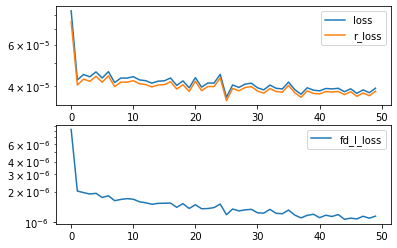

In [98]:
plt.subplot(2,1,1)
plt.plot(history[:,:2])
plt.legend(['loss','r_loss'])
plt.gca().set_yscale('log')

plt.subplot(2,1,2)
plt.plot(history[:,2:3])
plt.legend(['fd_l_loss'])
plt.gca().set_yscale('log')
plt.show()

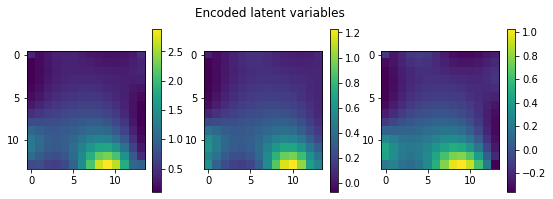

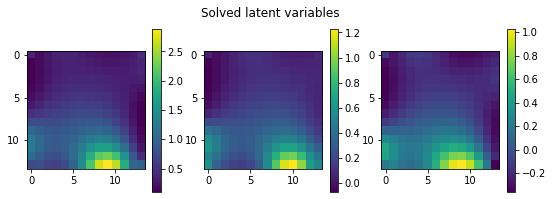

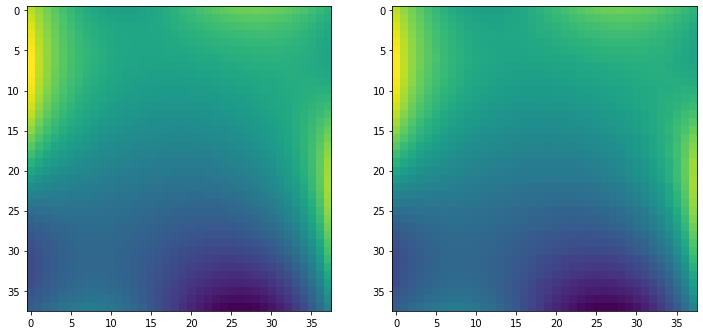

In [151]:
def GetAfxy_mat(a,b,c,d):
    A = np.zeros((3,3))
    A[0,0] = (b*d)/(a*c*(a + b)*(c + d))
    A[0,1] = (b*(c - d))/(a*c*d*(a + b))
    A[0,2] = -(b*c)/(a*d*(a + b)*(c + d))

    A[1,0] = (d*(a - b))/(a*b*c*(c + d))
    A[1,1] = ((a - b)*(c - d))/(a*b*c*d)
    A[1,2] = -(c*(a - b))/(a*b*d*(c + d))

    A[2,0] = -(a*d)/(b*c*(a + b)*(c + d))
    A[2,1] = -(a*(c - d))/(b*c*d*(a + b))
    A[2,2] = (a*c)/(b*d*(a + b)*(c + d))
    return A

def GetAfxx_mat(a,b,c,d):
    A = np.zeros((3,3))
    A[0,1] = 2/(a*(a + b))
    A[1,1] = -2/(a*b)
    A[2,1] = 2/(b*(a + b))
    return A

def GetAfx_mat(a,b,c,d):
    A = np.zeros((3,3))
    A[0,1] = -b/(a*(a + b))
    A[1,1] = -(a - b)/(a*b)
    A[2,1] = a/(b*(a + b))
    return A


def GetAfyy_mat(a,b,c,d):
    A = np.zeros((3,3))
    A[1,0] = 2/(c*(c + d))
    A[1,1] = -2/(c*d)
    A[1,2] = 2/(d*(c + d))
    return A

def GetAfy_mat(a,b,c,d):
    A = np.zeros((3,3))
    A[1,0] = -d/(c*(c + d))
    A[1,1] = -(c - d)/(c*d)
    A[1,2] = c/(d*(c + d))
    return A

def getA_mat(C,X,Y):
    a = X[1,1]-X[0,1]
    b = X[2,1]-X[1,1]
    c = Y[1,1]-Y[1,0]
    d = Y[1,2]-Y[1,1]
    Afxy = GetAfxy_mat(a,b,c,d)
    Afxx = GetAfxx_mat(a,b,c,d)
    Afyy = GetAfyy_mat(a,b,c,d)
    Afx = GetAfx_mat(a,b,c,d)
    Afy = GetAfy_mat(a,b,c,d)
    Af = np.zeros((3,3))
    Af[1,1] = 1
    A = C[0]*Af + C[1]*Afx + C[2]*Afy + C[3]*Afxx + C[4]*Afyy + C[5]*Afxy
    return A

def GetAfxy(a,b,c,d):
    Asw = (b*d)/(a*c*(a + b)*(c + d))
    Aw = (b*(c - d))/(a*c*d*(a + b))
    Anw = -(b*c)/(a*d*(a + b)*(c + d))

    As = (d*(a - b))/(a*b*c*(c + d))
    Ap = ((a - b)*(c - d))/(a*b*c*d)
    An = -(c*(a - b))/(a*b*d*(c + d))

    Ase = -(a*d)/(b*c*(a + b)*(c + d))
    Ae = -(a*(c - d))/(b*c*d*(a + b))
    Ane = (a*c)/(b*d*(a + b)*(c + d))
    return Asw,Aw,Anw,As,Ap,An,Ase,Ae,Ane

def Aij(Cij,u_bc,X,Y):   
    n = u_bc.shape[0]
    Ap = np.zeros((n-2,n-2))
    An = np.zeros((n-2,n-2))
    As = np.zeros((n-2,n-2))
    Aw = np.zeros((n-2,n-2))
    Ae = np.zeros((n-2,n-2))
    Anw = np.zeros((n-2,n-2))
    Ane = np.zeros((n-2,n-2))
    Asw = np.zeros((n-2,n-2))
    Ase = np.zeros((n-2,n-2))
    for i in range(0,n-2):
        for j in range(0,n-2):
            A = getA_mat(Cij,X[i:i+3,j:j+3],Y[i:i+3,j:j+3])
            Ap[i,j] = A[1,1]
            An[i,j] = A[1,2]
            As[i,j] = A[1,0]
            Aw[i,j] = A[0,1]
            Ae[i,j] = A[2,1]
            Anw[i,j] = A[0,2]
            Ane[i,j] = A[2,2]
            Asw[i,j] = A[0,0]
            Ase[i,j] = A[2,0]

    b = np.zeros((n-2,n-2))
    b[0,:] -= Aw[0,:]*u_bc[0,1:-1]
    Aw[0,:] = 0
    b[:,-1] -= An[:,-1]*u_bc[1:-1,-1]
    An[:,-1] = 0
    b[-1,:] -= Ae[-1,:]*u_bc[-1,1:-1]
    Ae[-1,:] = 0
    b[:,0] -= As[:,0]*u_bc[1:-1,0]
    As[:,0] = 0

    b[0,:] -= Anw[0,:]*u_bc[0,2:] # w border
    Anw[0,:] = 0
    b[1:,-1] -= Anw[1:,-1]*u_bc[1:-2,-1] # n border
    Anw[1:,-1] = 0
    b[-1,:] -= Ane[-1,:]*u_bc[-1,2:] # e border
    Ane[-1,:] = 0
    b[:-1,-1] -= Ane[:-1,-1]*u_bc[2:-1,-1] # n border
    Ane[:-1,-1] = 0

    b[0,:] -= Asw[0,:]*u_bc[0,:-2] # w border
    Asw[0,:] = 0
    b[1:,0] -= Asw[1:,0]*u_bc[1:-2,0] # s border
    Asw[1:,0] = 0
    b[-1,:] -= Ase[-1,:]*u_bc[-1,:-2] # e border
    Ase[-1,:] = 0
    b[:-1,0] -= Ase[:-1,0]*u_bc[2:-1,0] # s border
    Ase[:-1,0] = 0

    A = sparse.diags(Ap.flatten())\
    + sparse.diags(An.flatten()[:-1],1) + sparse.diags(As.flatten()[1:],-1)\
    + sparse.diags(Ae.flatten()[:-(n-2)],(n-2)) + sparse.diags(Aw.flatten()[(n-2):],-(n-2))\
    + sparse.diags(Ane.flatten()[:-1-(n-2)],1+(n-2)) + sparse.diags(Anw.flatten()[(n-2)-1:],1-(n-2))\
    + sparse.diags(Ase.flatten()[:-(n-2)+1],(n-2)-1) + sparse.diags(Asw.flatten()[(n-2)+1:],-(n-2)-1)
    A = A.tocsr()
    b = b.flatten()
    return A,b

def SolveProblem(C,u_bc,X,Y):
    n = u_bc.shape[-1]
    n_latent = C.shape[0]

    A = [[[None] for i in range(n_latent)] for j in range(n_latent)]
    # A = [[None,None],[None,None]]
    b = np.zeros((n_latent,n_latent,(n-2)**2))
    for i in range(n_latent):
        for j in range(n_latent):
            A_ij,b_ij = Aij(C[i,j],u_bc[j],X,Y)
            A[i][j] = A_ij
            b[i,j,:] = b_ij

    A = [sparse.hstack(A[i]) for i in range(n_latent)]
    A = sparse.vstack(A)
    b = np.sum(b,axis=1)
    b = np.expand_dims(np.concatenate(b),axis=-1)
    u = spsolve(A,b)
    u = np.array(np.split(u,n_latent))
    u = u.reshape((n_latent,n-2,n-2))
    u_bc[:,1:-1,1:-1] = u
    return u_bc

def GetRandBC(n,X,Y):
    # X,Y = np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,n))
    ang = np.arctan2(Y,X)
    # rcoef = [ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,   -2.3015387 ]
    rcoef = np.random.randn(6)
    U = rcoef[0]*np.sin(ang)+rcoef[1]*np.cos(ang)+rcoef[2]*np.sin(2*ang)+rcoef[3]*np.cos(2*ang)+rcoef[4]*np.sin(3*ang)+rcoef[5]*np.cos(3*ang)
    U[1:-1,1:-1] = 0
    return U

def GetRandBCnd(n_latent,n,X,Y):
    u_bc = np.zeros((n_latent,n,n))
    for i in range(n_latent):
        u_bc[i] = GetRandBC(n,X,Y)
    return u_bc

def PickCorner0(T,n_input,overlap):
  T_c_i = np.zeros((1,n_input+2*overlap,T.shape[-1]))
  T_c_i[:,int((n_input+2*overlap-1)/2),:] = T[0,0,:]
  for i in range(int((n_input+2*overlap-1)/2)):
    T_c_i[:,int((n_input+2*overlap-1)/2)+i+1,:] = T[0,1+i,:]
    T_c_i[:,int((n_input+2*overlap-1)/2)-i-1,:] = T[1+i,0,:]
  return T_c_i

def PickEdge0(T,n_input,overlap,n_grid_i):
  T_e_i = np.zeros((n_grid_i,n_input+2*overlap,T.shape[-1]))
  for i in range(n_grid_i):
    T_e_i[i] = T[0,i*n_input+1-overlap:(i+1)*n_input+1+overlap]
  return T_e_i

def EvalOnBC(T_sample,B_sample,mesh,encoder,encoderB,decoder,P,n_input,overlap):
  n_grid_i = int((T_sample.shape[0]-2)/n_input)
  T_i = T_sample[1-overlap:T_sample.shape[0]-1+overlap,1-overlap:T_sample.shape[1]-1+overlap]
  T_i_arr = []
  for i in range(n_grid_i):
    T_i_i = T_i[:,i*n_input-overlap:(i+1)*n_input+overlap,:]
    T_i_arr.append(T_i_i)
  T_i = np.stack(T_i_arr,0)

  T_i_arr = []
  for i in range(n_grid_i):
    T_i_i = T_i[:,i*n_input-overlap:(i+1)*n_input+overlap,:]
    T_i_arr.append(T_i_i)
  T_i = np.stack(T_i_arr,0)
  T_ir = T_i.reshape((T_i.shape[0]*T_i.shape[1],T_i.shape[2],T_i.shape[3],T_i.shape[4]))
  l_ir = encoder(T_ir)
  l_i = np.reshape(l_ir,(T_i.shape[0],T_i.shape[1],l_ir.shape[-1]))
  latent = np.zeros((n_grid_i+2,n_grid_i+2,n_latent))

  T_e = []
  B_e = []
  T_c = []
  B_c = []
  l_e = []
  l_c = []

  for i in range(4):
    T_rot = np.rot90(T_sample,i,(0,1))
    B_rot = np.rot90(B_sample,i,(0,1))

    T_e_i = PickEdge0(T_rot,n_input,overlap,n_grid_i)
    B_e_i = PickEdge0(B_rot,n_input,overlap,n_grid_i)
    T_c_i = PickCorner0(T_rot,n_input,overlap)
    B_c_i = PickCorner0(B_rot,n_input,overlap)

    T_e.append(T_e_i)
    B_e.append(B_e_i)
    T_c.append(T_c_i)
    B_c.append(B_c_i)

    l_e_i = encoderB([T_e_i,B_e_i])
    l_c_i = encoderB([T_c_i,B_c_i])

    latent = np.rot90(latent,i,(0,1))
    latent[0,0,:] = l_c_i[0]
    latent[0,1:-1] = l_e_i
    latent = np.rot90(latent,-i,(0,1))

  latentBC = latent.copy()
  latent[1:-1,1:-1] = l_i

  CC = np.zeros((n_latent,n_latent,6))

  Cnp = GetC(P).numpy()
  CC[:,:,3] = Cnp[:,:,0]
  CC[:,:,4] = Cnp[:,:,1]
  CC[:,:,5] = Cnp[:,:,2]
  latent_bc = np.moveaxis(latent.copy(),-1,0)
  latent_bc[:,1:-1,1:-1]=0

  nx = mesh.shape[0]
  d_idx = int(np.floor(n_input/2))
  latent_ix = [0]+list(range(1+d_idx,nx,n_input))+[nx-1]
  Iy,Ix = np.meshgrid(latent_ix,latent_ix)
  l_mesh = mesh[Ix,Iy,:]
  X = l_mesh[:,:,0]
  Y = l_mesh[:,:,1]

  latent_r = SolveProblem(CC,latent_bc,X,Y)
  latent_r = np.moveaxis(latent_r,0,-1)\

  # decode solved latent space
  latent_d = latent_r[1:-1,1:-1]
  latent_d_r = latent_d.reshape((latent_d.shape[0]*latent_d.shape[1],latent_d.shape[2]))
  T_recon_r = decoder(latent_d_r)
  T_recon = np.reshape(T_recon_r,(latent_d.shape[0],latent_d.shape[1],T_recon_r.shape[1],T_recon_r.shape[2],T_recon_r.shape[3]))
  T_recon = np.concatenate(T_recon,1)
  T_recon = np.concatenate(T_recon,1)
  T_recon_i = T_recon
  T_recon = T_sample.copy()
  T_recon[1:-1,1:-1] = T_recon_i
  return T_recon, latent, latent_r

def EvalBatch(T_batch,B_batch,mesh,encoder,encoderB,decoder,P,n_input,overlap):
  T_recon_arr = []
  latent_arr = []
  latent_r_arr = []
  for i in tqdm(range(T_batch.shape[0])):
      T_recon, latent, latent_r = EvalOnBC(T_batch[i],B_batch[i],mesh,encoder,encoderB,decoder,P,n_input,overlap)
      T_recon_arr.append(T_recon)
      latent_arr.append(latent)
      latent_r_arr.append(latent_r)
  
  T_recon = np.stack(T_recon_arr,0)
  latent = np.stack(latent_arr,0)
  latent_r = np.stack(latent_r_arr,0)
  err = np.square(T_recon-T_batch).mean((1,2,3))
  return err, T_recon, latent, latent_r
   


idx_T = 2

T_sample = T_train[idx_T]
B_sample = B_train[idx_T]

T_recon, latent, latent_r = EvalOnBC(T_sample,B_sample,mesh,encoder,encoderB,decoder,P,n_input,overlap)

latent_m = latent*np.sign(latent[-2:-1,-2:-1,:])
latent_m[[0,0,-1,-1],[0,-1,0,-1],:] = latent_m.mean((0,1))
l_max = np.max(latent_m,axis=(0,1))
l_min = np.min(latent_m,axis=(0,1))

plt.figure(figsize=(n_latent*3,3))
for i in range(n_latent):
    ax = plt.subplot(1,n_latent,i+1)
    pcm = ax.imshow(latent[:,:,i]*np.sign(latent[-2,-2,i]),vmax=l_max[i],vmin=l_min[i])
    plt.colorbar(pcm)
plt.suptitle("Encoded latent variables")
plt.show()

plt.figure(figsize=(n_latent*3,3))
for i in range(n_latent):
    ax = plt.subplot(1,n_latent,i+1)
    pcm = ax.imshow(latent_r[:,:,i]*np.sign(latent[-2,-2,i]),vmax=l_max[i],vmin=l_min[i])
    plt.colorbar(pcm)
plt.suptitle("Solved latent variables")
plt.show()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(T_sample)
plt.subplot(1,2,2)
plt.imshow(T_recon)
plt.show()

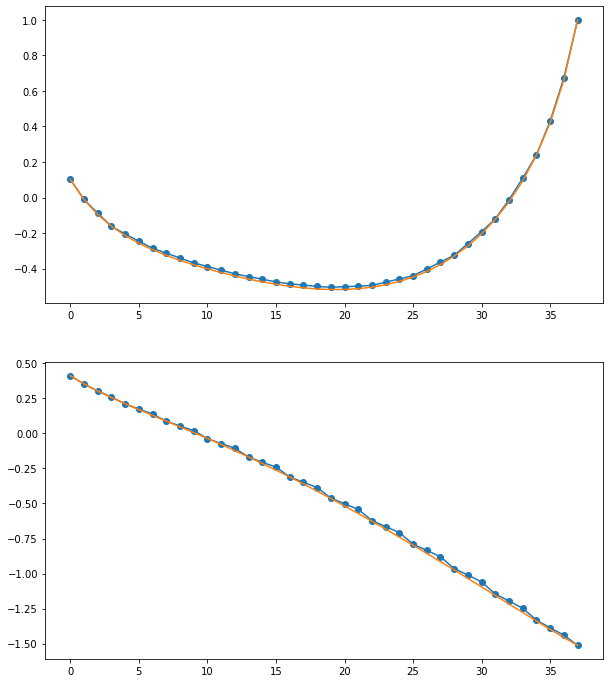

In [152]:
  plt.figure(figsize=(10,12))

  ix = 20
  plt.subplot(2,1,1)
  plt.plot(T_recon[ix,:],'-o')
  plt.plot(T_sample[ix,:])

  iy = 20
  plt.subplot(2,1,2)
  plt.plot(T_recon[:,iy],'-o')
  plt.plot(T_sample[:,iy])

  plt.show()

In [170]:
err,T_recon,latent,latent_r = EvalBatch(T_train[:1000],B_train[:1000],mesh,encoder,encoderB,decoder,P,n_input,overlap)
err.mean()

100%|██████████| 1000/1000 [02:18<00:00,  7.20it/s]


0.00010310172961157394

In [171]:
latent.shape

(1000, 14, 14, 3)

In [172]:
import modred as mr
num_modes = 5
latenti = latent[:,:,:,0]
data_MD = np.reshape(latenti,(latenti.shape[0],latenti.shape[1]*latenti.shape[2]))
POD_res = mr.compute_POD_arrays_snaps_method(data_MD.transpose(), list(mr.range(num_modes)))
modes = np.reshape(POD_res.modes,(latenti.shape[1],latenti.shape[2],num_modes))

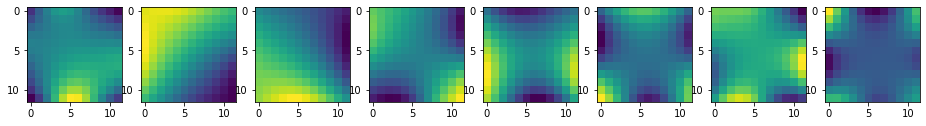

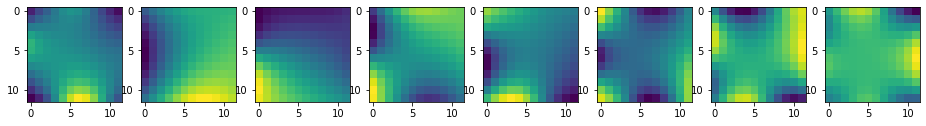

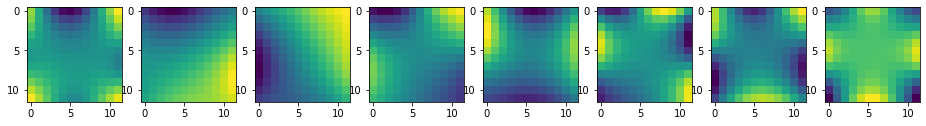

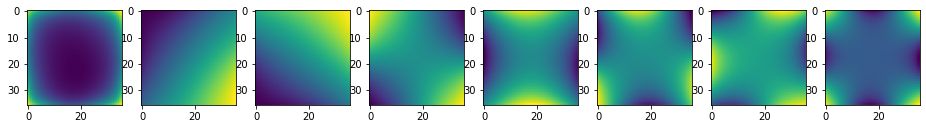

In [180]:
num_modes = 8
for j in range(latent.shape[-1]):
    latenti = latent[:,1:-1,1:-1,j]
    data_MD = np.reshape(latenti,(latenti.shape[0],latenti.shape[1]*latenti.shape[2]))
    POD_res = mr.compute_POD_arrays_snaps_method(data_MD.transpose(), list(mr.range(num_modes)))
    modes = np.reshape(POD_res.modes,(latenti.shape[1],latenti.shape[2],num_modes))
    plt.figure(figsize=(16,4))
    for i in range(num_modes):
        plt.subplot(1,num_modes,i+1)
        plt.imshow(modes[:,:,i])
    plt.show()

T_batch = T_train[:1000,1:-1,1:-1,0]
data_MD = np.reshape(T_batch,(T_batch.shape[0],T_batch.shape[1]*T_batch.shape[2]))
POD_res = mr.compute_POD_arrays_snaps_method(data_MD.transpose(), list(mr.range(num_modes)))
modes = np.reshape(POD_res.modes,(T_batch.shape[1],T_batch.shape[2],num_modes))
plt.figure(figsize=(16,4))
for i in range(num_modes):
    plt.subplot(1,num_modes,i+1)
    plt.imshow(modes[:,:,i])
plt.show()